In [7]:
import torch

In [8]:
from transformers import XLMRobertaTokenizer

In [2]:
import os
import gzip
import pickle 

from collections import defaultdict
from itertools import cycle

In [10]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
print(f"Total size of subword vocab: {tokenizer.vocab_size}")

Total size of subword vocab: 250002


In [11]:
def get_data_size(lng): 
    """ Calculate the size of a diretory in byes"""
    lng_root = f"data/oscar/{lng}"
    language_filenames = os.listdir(lng_root)
    size = 0 
    for filename in language_filenames:
        filepath = os.path.join(lng_root, filename)
        size += os.stat(filepath).st_size
    return size

In [12]:
def get_data_stream(lng):
    """ Get a datastream for a particular language """
    lng_root = f"data/oscar/{lng}"
    language_filenames = os.listdir(lng_root)
    for filename in language_filenames:
        filepath = os.path.join(lng_root, filename)
        with gzip.open(filepath) as gzip_buffer: 
            for line in gzip_buffer:
                yield line

#### Global variables for analysis

In [115]:
MAX_LINES = 2_000_000
REPORT_EVERY = 1_000

In [16]:
def run_analyses(lng):
    ''' 
    For a given language: (lng) runs analyses of the vocab size
    resulting from reading in n number of sentences, also returns 
    other relevant information about a given dataset, like the size 
    of the dataset, and the final set of vocabulary subwords.
    
    Args: 
        * lng (str): The current language (useful for multiprocessing)
    Args: 
        * analysis_result (dict) containing the following entries 
            * data_size (int): Size of the dataset in bytes 
            * lng (str): The current language (useful for multiprocessing)
            * lines_to_size (dict): Maps (max_lines) -> (size of subword vocab covered)
                for a range of max lines
            * vocab (set): set with all of the subword vocab words 
    '''
    
    lines_to_size = {}
    subword_to_sample = defaultdict(list)
    
    data_size = get_data_size(lng) # in bytes
    stream = get_data_stream(lng)
    
    for idx, line in enumerate(stream):

        if idx > MAX_LINES:
            break

        # decoding and tokenizing next line 
        tokenized_line = tokenizer(line.decode('utf-8'))
        input_ids = tokenized_line['input_ids']

        for input_id in input_ids: 
            subword_to_sample[input_id].append(idx)

        '''
        Logic for reporting out values:
        * for the first 5000 we report every 100 sentences 
        * after that we report every REPORT_EVERY sentences
        '''
        
        if idx < 5_000:
            if (idx % 100 == 0): 
                lines_to_size[idx] = len(subword_to_sample) 
        else: 
            if (idx % REPORT_EVERY == 0):
                lines_to_size[idx] = len(subword_to_sample)
    else:
        # we only get here if we have read through all available data 
        lines_to_size[idx] = len(subword_to_sample)
        
        
    analysis_result = {
        "data_size": data_size,
        "lng": lng,
        "lines_to_size": lines_to_size,
        "subword_to_sample": set(subword_to_sample.keys())
    }
    
    return analysis_result

#### Running Analysis 

Analysis run on the languages that are part of the cc100 dataset

In [17]:
from multiprocessing import Pool, cpu_count

In [18]:
# Loading in languages to process 
with open("configs/demo/cc100_languages.txt") as f: 
    languages = f.read().splitlines()
print(languages)

['af', 'am', 'ar', 'as', 'az', 'be', 'bg', 'bn', 'br', 'bs', 'ca', 'cs', 'cy', 'da', 'de', 'el', 'en', 'eo', 'es', 'et', 'eu', 'fa', 'fi', 'fr', 'fy', 'ga', 'gd', 'gl', 'gu', 'he', 'hi', 'hr', 'hu', 'hy', 'id', 'is', 'it', 'ja', 'jv', 'ka', 'kk', 'km', 'kn', 'ko', 'ku', 'ky', 'la', 'lo', 'lt', 'lv', 'mg', 'mk', 'ml', 'mn', 'mr', 'ms', 'my', 'ne', 'nl', 'no', 'or', 'pa', 'pl', 'ps', 'pt', 'ro', 'ru', 'sa', 'si', 'sd', 'sk', 'sl', 'so', 'sq', 'sr', 'su', 'sv', 'sw', 'ta', 'te', 'th', 'tl', 'tr', 'ug', 'uk', 'ur', 'uz', 'vi', 'yi', 'zh']


In [19]:
pool_size = min(cpu_count(), len(languages))
print(f"Spawning pool with {pool_size} workers")
with Pool(len(languages)) as p: 
    analyses_results = p.map(run_analyses, languages)

Spawning pool with 28 workers


Token indices sequence length is longer than the specified maximum sequence length for this model (1321 > 512). Running this sequence through the model will result in indexing errorsToken indices sequence length is longer than the specified maximum sequence length for this model (1258 > 512). Running this sequence through the model will result in indexing errorsToken indices sequence length is longer than the specified maximum sequence length for this model (811 > 512). Running this sequence through the model will result in indexing errorsToken indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors


Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# storing result 
with open("data_2M.pkl", "wb") as f:
    pickle.dump(analyses_results, f)

## Plotting Analysis

Possibly loading in data if already generated

In [1]:
import pickle
with open("data_2M.pkl", "rb") as f:
    analyses_results = pickle.load(f)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
for analysis_result in analyses_results:
    raw_sample_counts, raw_vocab_words  = zip(*analysis_result['lines_to_size'].items())
    print(f"For language: {analysis_result['lng']} Size of total subword vocab: {raw_vocab_words[-1]}")

We are looking to solve the following problem - after sampling x% of the dataset what % of the total subw

/rds/user/rd654/hpc-work/problyglot/env/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Largest dataset size with less than 105000 sentences: 13.712469 Mb


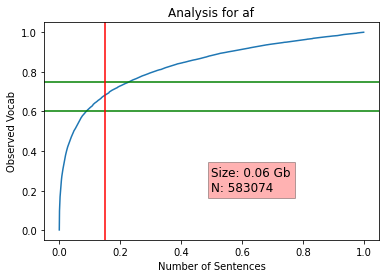

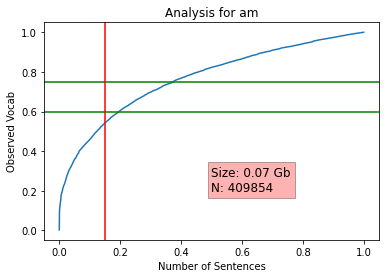

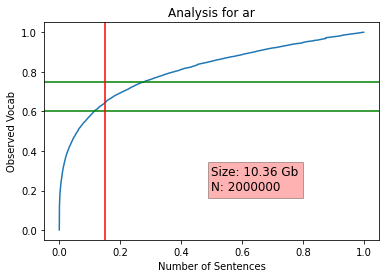

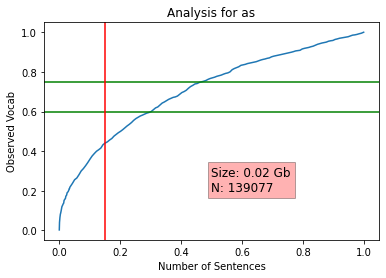

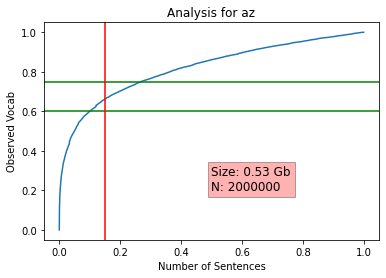

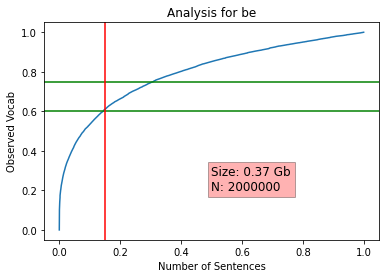

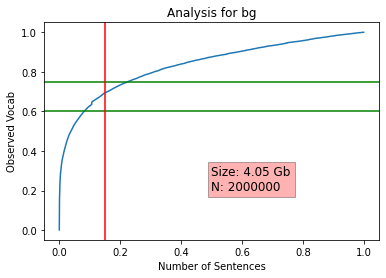

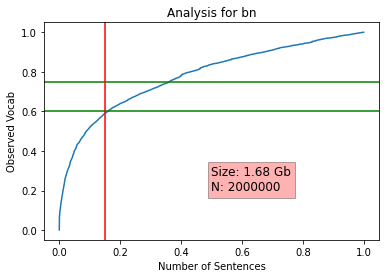

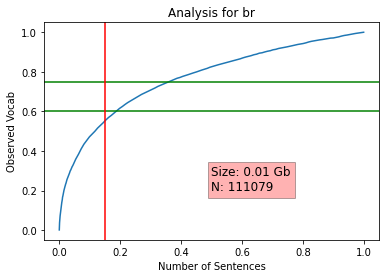

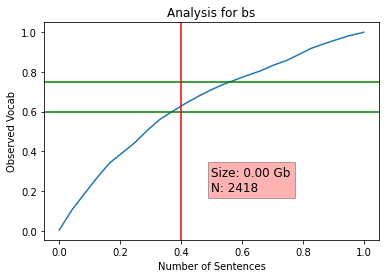

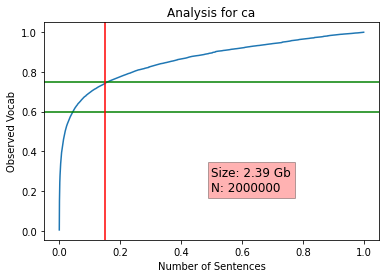

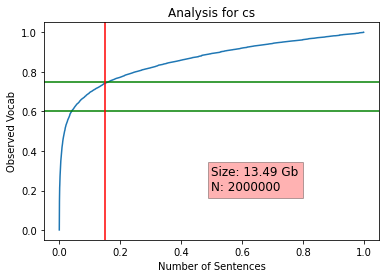

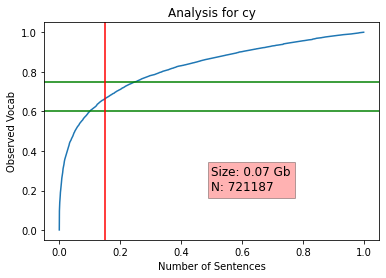

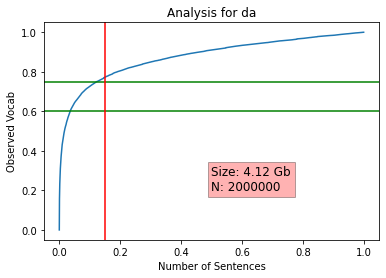

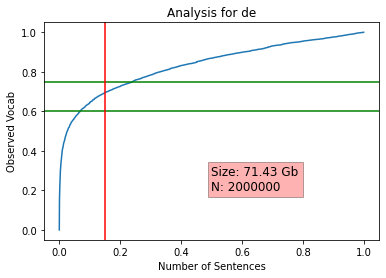

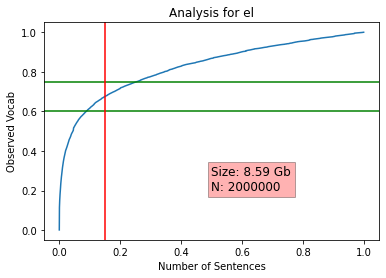

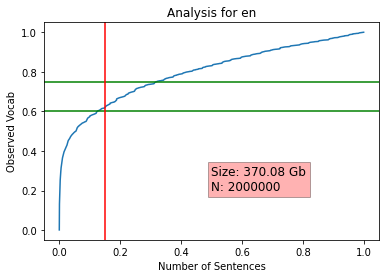

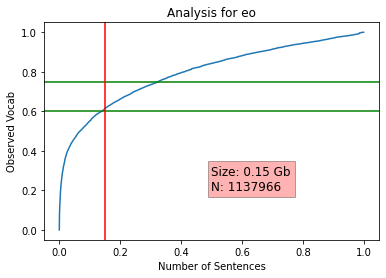

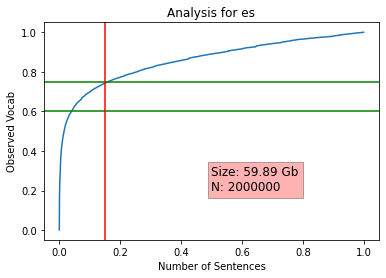

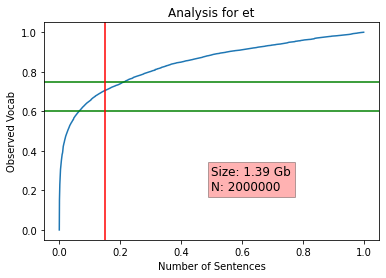

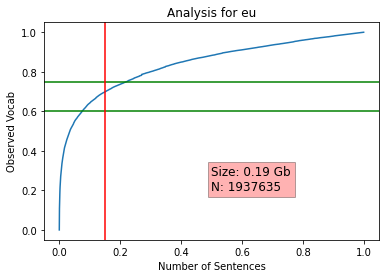

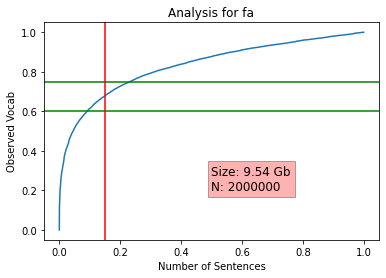

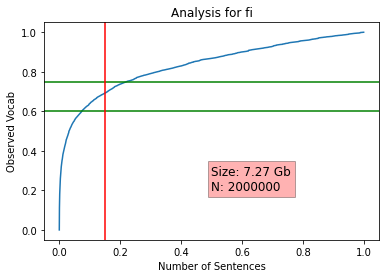

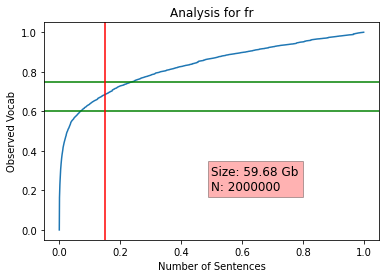

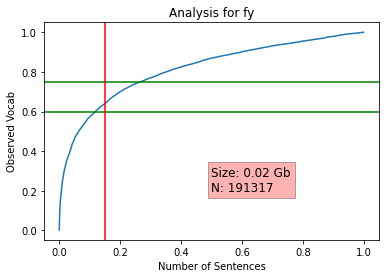

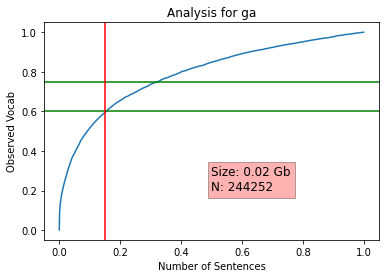

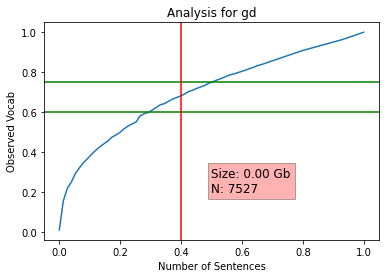

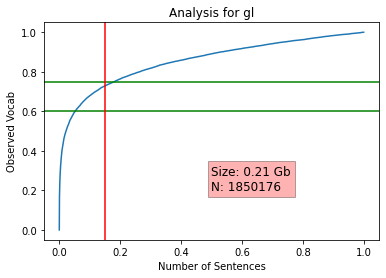

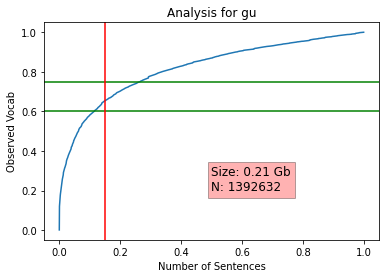

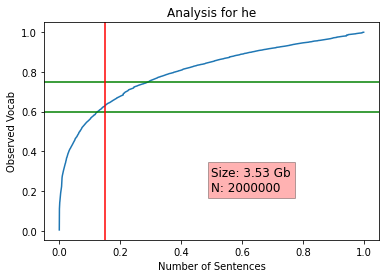

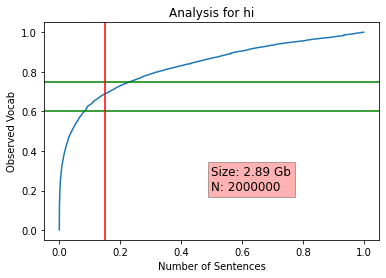

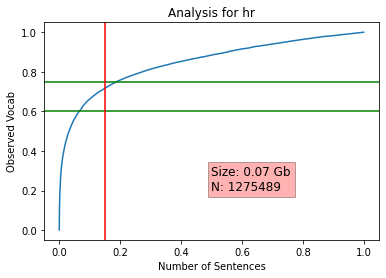

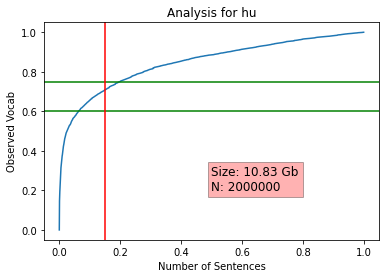

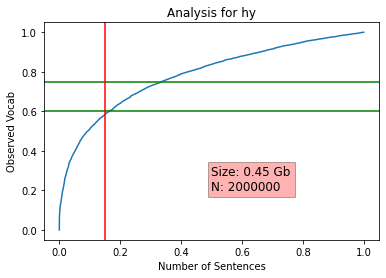

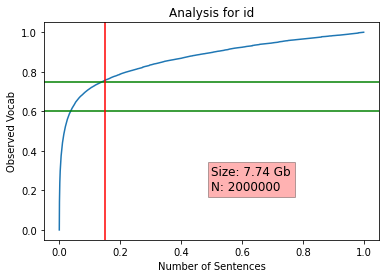

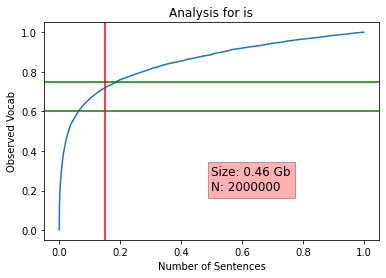

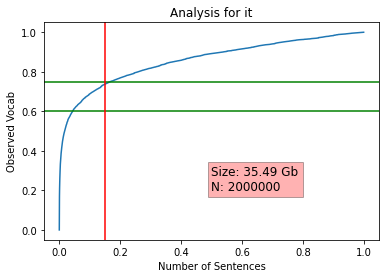

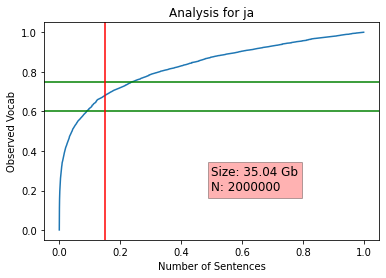

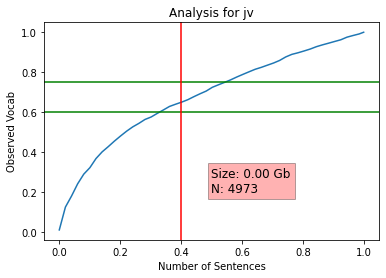

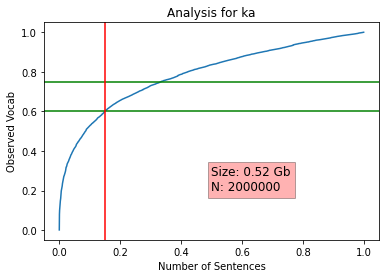

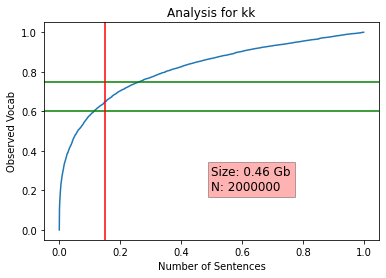

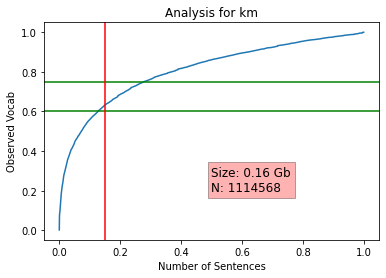

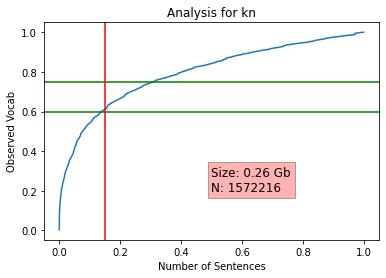

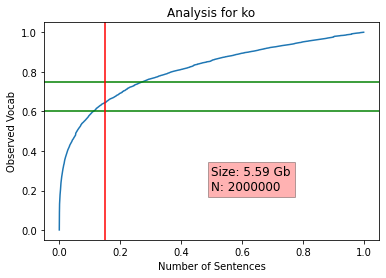

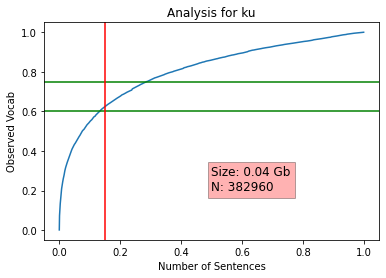

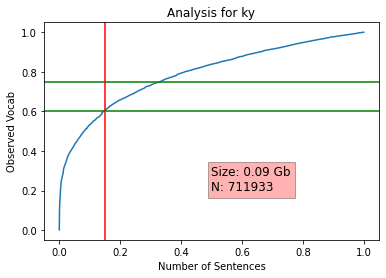

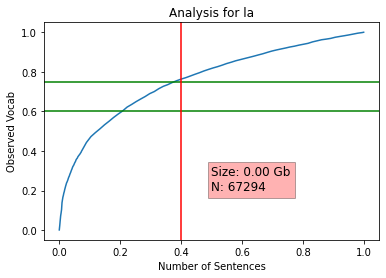

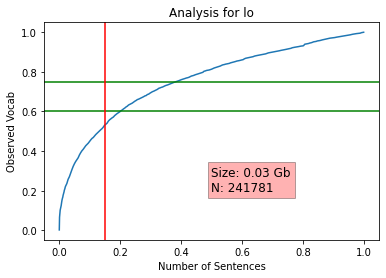

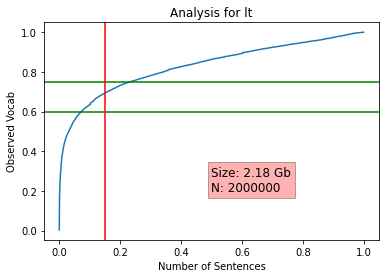

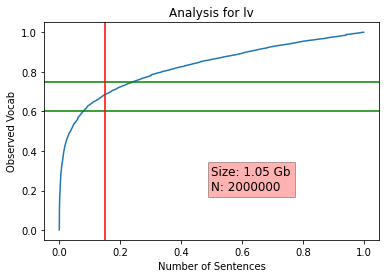

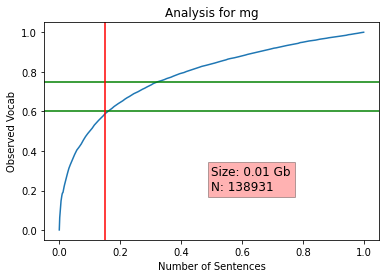

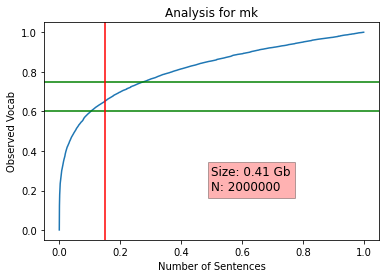

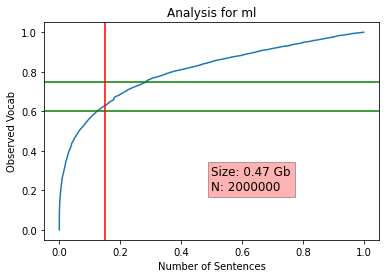

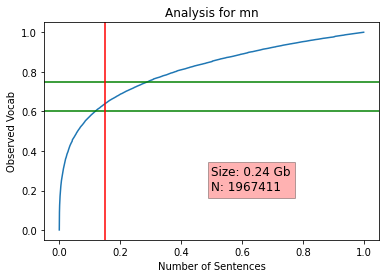

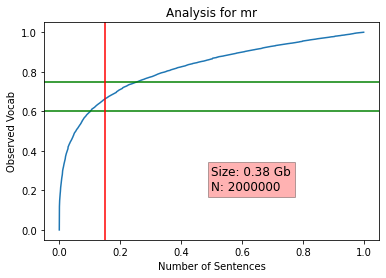

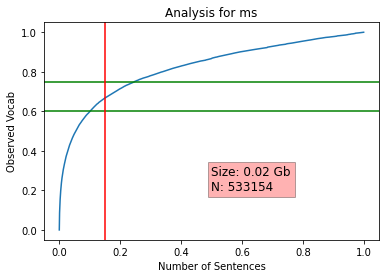

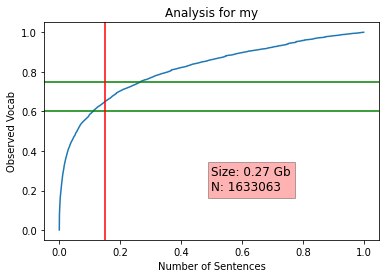

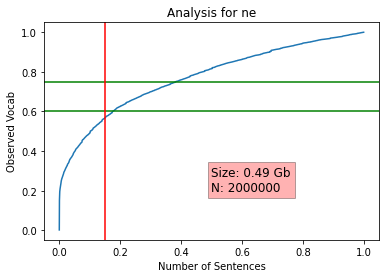

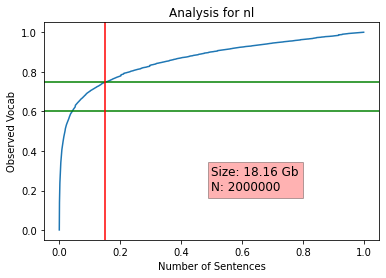

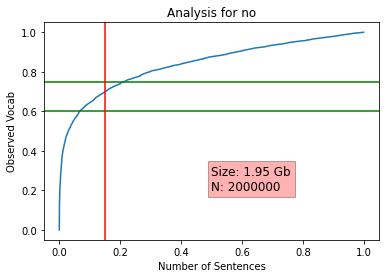

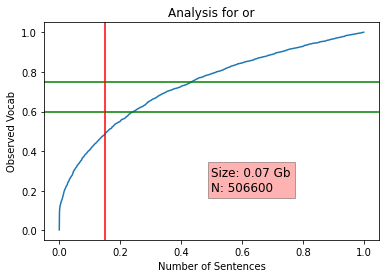

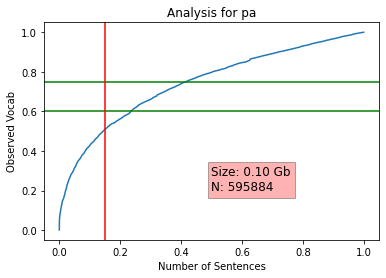

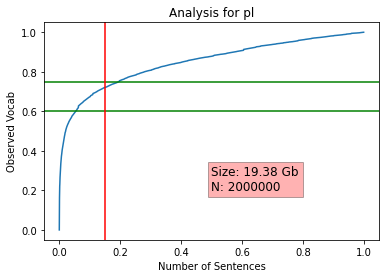

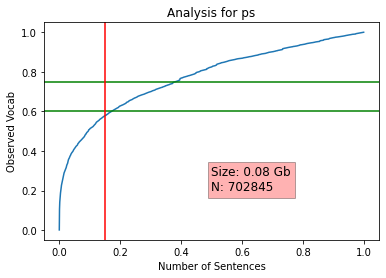

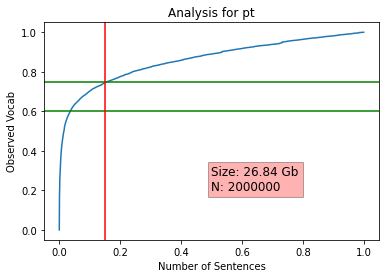

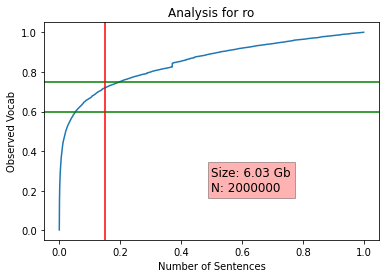

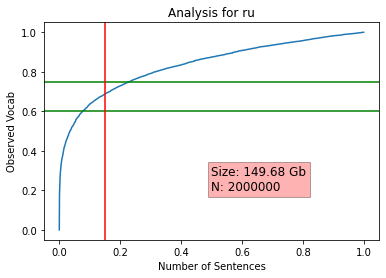

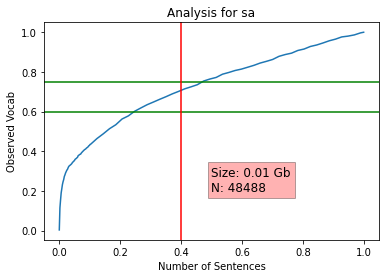

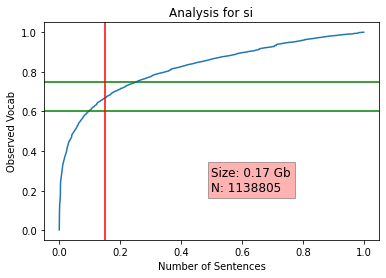

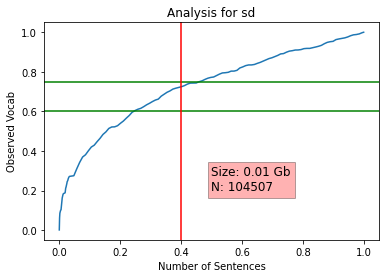

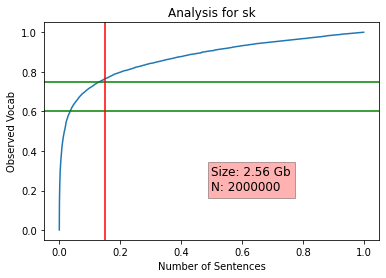

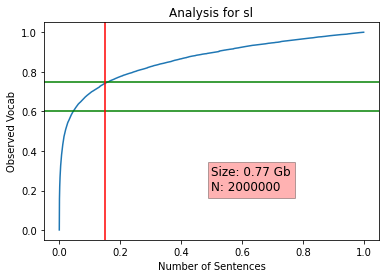

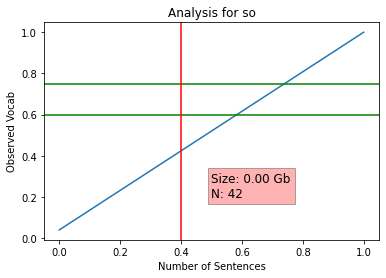

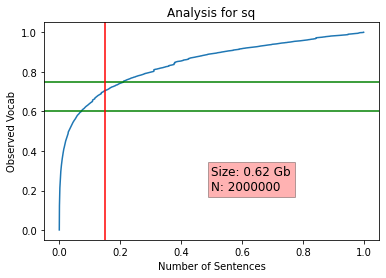

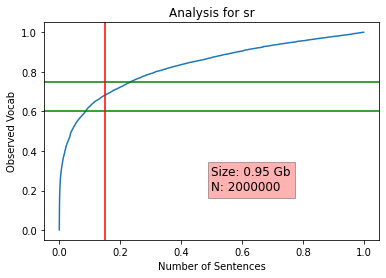

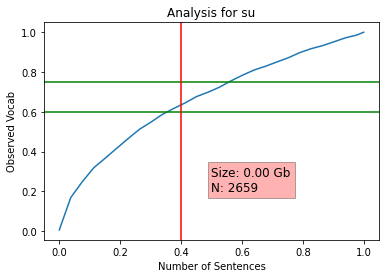

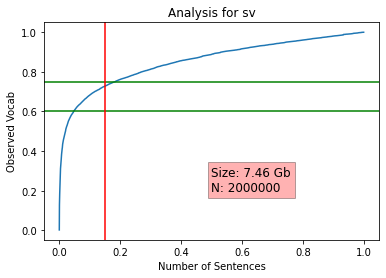

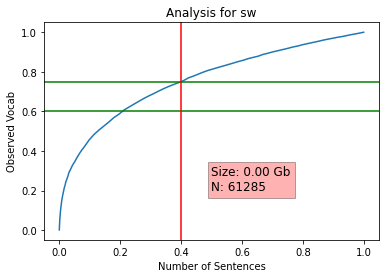

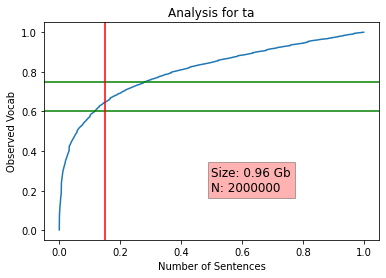

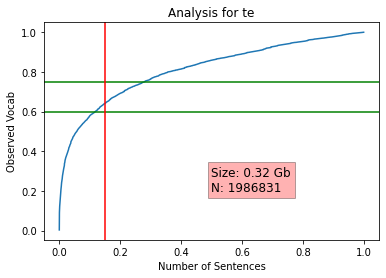

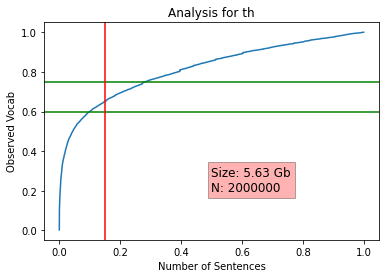

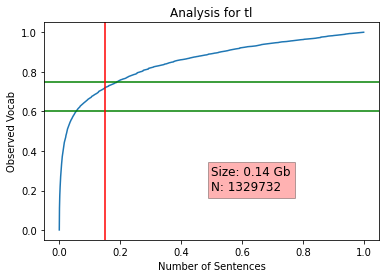

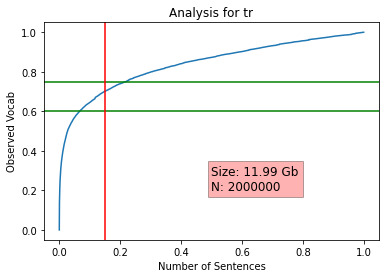

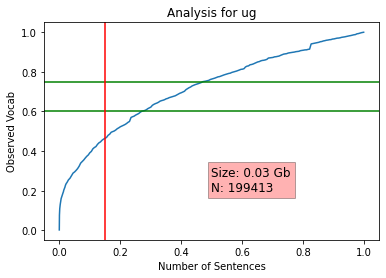

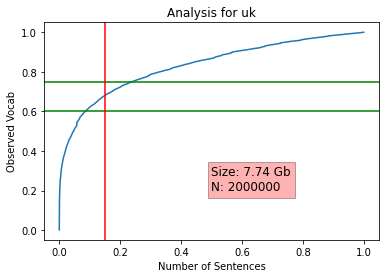

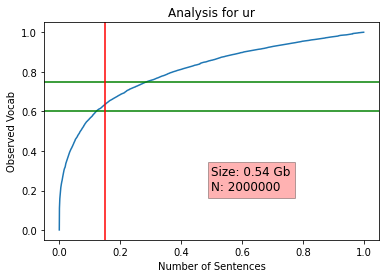

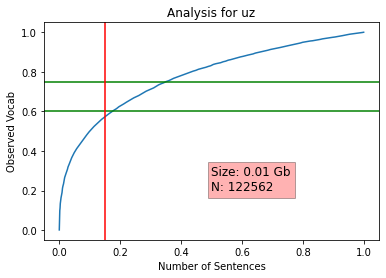

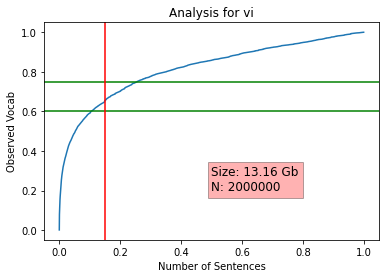

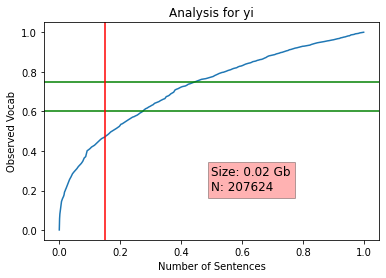

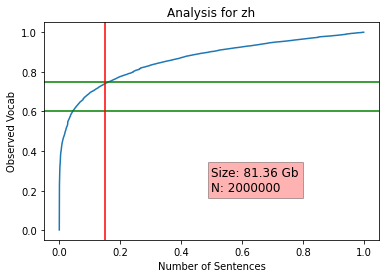

In [6]:
max_small_data_size = 0
MAX_DECISION_BOUNDARY = 105_000

for analysis_result in analyses_results:
    raw_sample_counts, raw_vocab_words  = zip(*analysis_result['lines_to_size'].items())

    np_raw_sample_counts = np.array(raw_sample_counts)
    np_raw_vocab_words = np.array(raw_vocab_words)

    sample_counts_relative = np_raw_sample_counts / np_raw_sample_counts[-1]
    vocab_words_relative = np_raw_vocab_words / np_raw_vocab_words[-1]

    fig, ax = plt.subplots()
    ax.plot(sample_counts_relative, vocab_words_relative)
    ax.set_xlabel("Number of Sentences")
    ax.set_ylabel("Observed Vocab")
    ax.set_title(f"Analysis for {analysis_result['lng']}")
    ax.axhline(y=0.6, color='g')
    ax.axhline(y=0.75, color='g')

    ax.text(0.5,0.2,"Size: {:.2f} Gb\nN: {}".format(analysis_result["data_size"]/1e9, raw_sample_counts[-1]), fontsize=12, bbox=dict(facecolor='red', alpha=0.3))
    
    if (raw_sample_counts[-1] < MAX_DECISION_BOUNDARY):
        max_small_data_size = max(max_small_data_size, analysis_result["data_size"]/1e6)
        
    if (raw_sample_counts[-1] < MAX_DECISION_BOUNDARY):
        ax.axvline(x=0.4, color='r')
    else:
        ax.axvline(x=0.15, color='r')

print(f"Largest dataset size with less than {MAX_DECISION_BOUNDARY} sentences: {max_small_data_size} Mb")
